In [1]:
import torch
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
# Datasets
from pyspdetection.networks.generators import BarabasiAlbertNetworks, RealNetwork, ErdosReyniNetworks
from pyspdetection.networks.modifiers import RemoveRandomEdges
from pyspdetection.networks.base import TemporalNetworks
from pyspdetection.dynamics import LotkaVolterraDynamics, SISDynamics, ThetaDynamics
from pyspdetection.dataset import Dataset

# Models
from pyspdetection.gnn import SISPredictor, GNNConfig
from pyspdetection.bayesian import BayesianSamplingModel, BayesConfig
from pyspdetection.reconstruction import ReconstructionConfig, CorrelationModel, GrangerCausality

# Dataset

### Network

In [34]:
# Barabasi Albert
graph_generator = BarabasiAlbertNetworks(N=30, m=1)

# Erdos
# graph_generator = ErdosReyniNetworks(N=100, density=0.1)

In [35]:
G = graph_generator()

### Perturbation: Remove random edges

In [36]:
modifier = RemoveRandomEdges(n_edges=5)

### Dynamics: SIS

In [51]:
sis_p, sis_q = 0.1, 0.1
dynamics = SISDynamics(p=sis_p, q=sis_q)

### Generate a timeseries of length 100 steps

In [52]:
t_perturb = 100
temporal_network = TemporalNetworks.from_modifiers(modifiers=[(t_perturb, modifier)], 
                                                   graph_generator=graph_generator)
dataset = Dataset(temporal_network, dynamics)

T = np.arange(200)
Xtrain = dataset.time_series(T, burn=100)
G0 = temporal_network(0)
G1 = temporal_network(T[-1])
W0 = nx.to_numpy_array(G0)
W1 = nx.to_numpy_array(G1)
dW = W0-W1

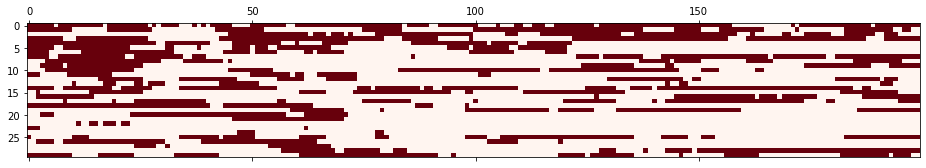

In [53]:
plt.matshow(Xtrain.T, cmap="Reds")

Text(0.5, 1.0, 'Target perturbation')

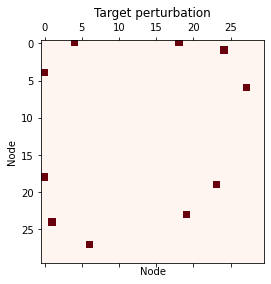

In [54]:
plt.matshow(W0-W1, cmap="Reds")
plt.xlabel("Node")
plt.ylabel("Node")
plt.title('Target perturbation')

# GNN

In [55]:
predictor = SISPredictor(config=GNNConfig.SISNet())

In [56]:
dW_GNN = predictor.predict(Xtrain.T, W0, t_perturb)

100%|██████████| 10000/10000 [00:13<00:00, 736.77it/s]


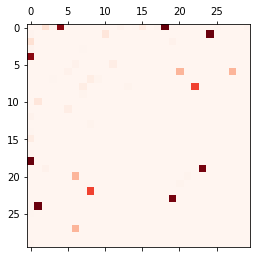

In [57]:
plt.matshow(dW_GNN, cmap="Reds")

# Bayesian approach

In [58]:
config = BayesConfig.paper()
config.set_sis(p=sis_p, q=sis_q)
bayesian_model = BayesianSamplingModel(config)

In [59]:
dW_bayesian = bayesian_model.predict(Xtrain.T, W0, t_perturb)

  0%|          | 0/2000 [00:00<?, ?it/s]/Users/edwardl/Documents/Personnel/structural-perturbation/pyspdetection/bayesian/likelihood.py:74: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1607370249289/work/aten/src/ATen/native/IndexingUtils.h:25.)
  p[inactive_index] = 1-p[inactive_index]
100%|██████████| 2000/2000 [00:01<00:00, 1108.44it/s]


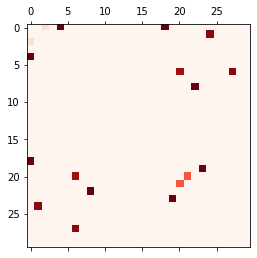

In [60]:
plt.matshow(dW_bayesian, cmap="Reds")

# Functional reconstruction methods

### Correlation

In [61]:
config = ReconstructionConfig.correlation()
corr_model = CorrelationModel(config)

In [62]:
dW_corr = corr_model.predict(Xtrain.T, W0, t_perturb)

/Users/edwardl/opt/miniconda3/envs/py_spdetection/lib/python3.8/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/edwardl/opt/miniconda3/envs/py_spdetection/lib/python3.8/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/edwardl/opt/miniconda3/envs/py_spdetection/lib/python3.8/site-packages/netrd/utilities/threshold.py:40: RuntimeWarning: Setting 'cutoffs' argument is strongly encouraged. Using cutoff range of (-1, 1).
  warnings.warn(


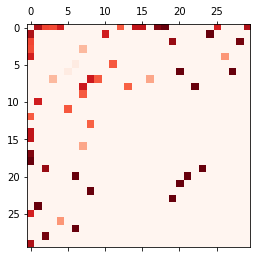

In [63]:
plt.matshow(dW_corr, cmap="Reds")

## Granger

In [64]:
config = ReconstructionConfig.granger()
granger_model = GrangerCausality(config)

In [65]:
dW_granger = corr_model.predict(Xtrain.T, W0, t_perturb)

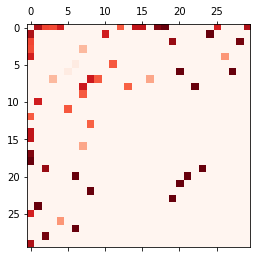

In [66]:
plt.matshow(dW_granger, cmap="Reds")

# Evaluation

# ROC 

In [67]:
from sklearn.metrics import roc_curve, auc

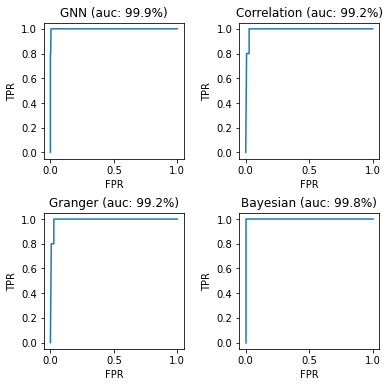

In [68]:
fpr_gnn, tpr_gnn, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_GNN.flatten())
fpr_coor, tpr_coor, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_corr.flatten())
fpr_granger, tpr_granger, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_granger.flatten())
fpr_bayesian, tpr_bayesian, _ = roc_curve((W0-W1).flatten().astype(np.int), dW_bayesian.flatten())


fig, axarr = plt.subplots(2, 2, figsize=(6,6))
k = 0 
for i in range(2):
    for j in range(2):
        ax = axarr[i,j]
        if k==0:
            ax.plot(fpr_gnn, tpr_gnn)
            ax.set_title(f'GNN (auc: {auc(fpr_gnn, tpr_gnn):.1%})')
        elif k==1:
            ax.plot(fpr_coor, tpr_coor)
            ax.set_title(f'Correlation (auc: {auc(fpr_coor, tpr_coor):.1%})')
        elif k==2:
            ax.plot(fpr_granger, tpr_granger)
            ax.set_title(f'Granger (auc: {auc(fpr_granger, tpr_granger):.1%})')
        else:
            ax.plot(fpr_bayesian, tpr_bayesian)
            ax.set_title(f'Bayesian (auc: {auc(fpr_bayesian, tpr_bayesian):.1%})')
        k += 1
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# Precision recall

In [74]:
from sklearn.metrics import precision_recall_curve, average_precision_score

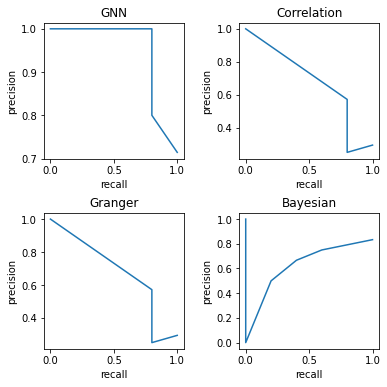

In [77]:
precision_gnn, recall_gnn, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_GNN.flatten())
precision_coor, recall_coor, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_corr.flatten())
precision_granger, recall_granger, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_granger.flatten())
precision_bayesian, recall_bayesian, _ = precision_recall_curve((W0-W1).flatten().astype(np.int), dW_bayesian.flatten())


fig, axarr = plt.subplots(2, 2, figsize=(6,6))
k = 0 
for i in range(2):
    for j in range(2):
        ax = axarr[i,j]
        if k==0:
            ax.plot(recall_gnn, precision_gnn)
            ax.set_title(f'GNN')
        elif k==1:
            ax.plot(recall_coor, precision_coor)
            ax.set_title('Correlation')
        elif k==2:
            ax.plot(recall_granger, precision_granger)
            ax.set_title('Granger')
        else:
            ax.plot(recall_bayesian, precision_bayesian)
            ax.set_title('Bayesian')
        k += 1
        ax.set_xlabel("recall")
        ax.set_ylabel("precision")
        
plt.subplots_adjust(wspace=0.4, hspace=0.4)